###1. Загрузка пакетов - библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, LSTM, GRU, Dropout
%matplotlib inline
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report
import time

###2. Загрузка данных

In [ ]:
csv_url = "https://media.githubusercontent.com/media/Daria-Chernykh/iad-lab2/refs/heads/main/V4_classification_lr3.csv?token=BFPF47TW636ZX6PJ7W4FYBDJGFBWW"
df = pd.read_csv(csv_url)
df["Cover_Type"] = df["Cover_Type"] - 1

###3. Описательная статистика

In [ ]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
# Используем метод info( ) для получения краткого описания данных, в частности общего числа строк, а также типов и количества ненулевых значений каждого атрибута
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505354 entries, 0 to 505353
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           505354 non-null  float64
 1   Aspect                              505354 non-null  float64
 2   Slope                               505354 non-null  float64
 3   Horizontal_Distance_To_Hydrology    505354 non-null  float64
 4   Vertical_Distance_To_Hydrology      505354 non-null  float64
 5   Horizontal_Distance_To_Roadways     505354 non-null  float64
 6   Hillshade_9am                       505354 non-null  float64
 7   Hillshade_Noon                      505354 non-null  float64
 8   Hillshade_3pm                       505354 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  505354 non-null  float64
 10  Wilderness_Area_0                   505354 non-null  float64
 11  Wilderness_Area_1         

Каждая строка в датасете представляет один участок местности площадью 30×30 метров, для которого требуется определить тип лесного покрова. Набор данных включает 54 атрибута, состоящих из количественных характеристик рельефа и бинарных индикаторов природных зон и типов почв.

1. Elevation - Высота над уровнем моря в метрах
2. Aspect - Угол обзора в градусах по азимуту
3. Slope - Уклон поверхности в градусах
4. Horizontal_Distance_To_Hydrology - Расстояние по горизонтали до ближайших поверхностных водных объектов
5. Vertical_Distance_To_Hydrology - Расстояние по вертикали до ближайших поверхностных водных объектов
6. Horizontal_Distance_To_Roadways - Расстояние по горизонтали до ближайшей проезжей части
7. Hillshade_9am - Индекс освещённости (затенения холмов) в 9 утра в день летнего солнцестояния
8. Hillshade_Noon - Индекс освещённости (затенения холмов) в полдень, летнее солнцестояние
9. Hillshade_3pm - Индекс освещённости (затенения холмов) в 3 часа дня, день летнего солнцестояния
10. Horizontal_Distance_To_Fire_Points - Расстояние по горизонтали до ближайших точек возгорания лесных пожаров

11-14. Wilderness_Area (4 binary columns) - Обозначение зоны дикой природы (Rawah, Neota, Comanche Peak, Cache la Poudre)

15-54. Soil_Type (40 binary columns) - Обозначение типа почвы

55. Cover_Type - Обозначение типа лесного покрова, целевой признак, принимающий значения от 0 до 6

В наборе данных содержится 505 354 наблюдения и 55 признаков. Все признаки, кроме целевого столбца Cover_Type, имеют тип float64, а целевая переменная представлена типом int64. Пропусков в данных нет.

Признаки можно разделить на три группы.

1. Количественные признаки рельефа и расстояний

    К этой группе относятся первые десять столбцов, содержащие числовые значения, описывающие характеристики участка местности:
    
    Elevation, Aspect, Slope, Horizontal_Distance_To_Hydrology, Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways, Hillshade_9am, Hillshade_Noon, Hillshade_3pm, Horizontal_Distance_To_Fire_Points.
    
    Все они являются количественными характеристиками, измеряемыми в метрах, градусах или индексах освещённости.

2. Бинарные категориальные признаки Wilderness_Area и Soil_Type

    Следующие 4 столбца Wilderness_Area_0–Wilderness_Area_3 представляют принадлежность участка к одной из природных зон. Каждый из них принимает значения 0 или 1.

    Далее следуют 40 столбцов Soil_Type_0–Soil_Type_39, также представленных бинарными индикаторами, обозначающими тип почвы.

    Эти признаки являются категориальными, но закодированы в виде отдельных бинарных переменных, что соответствует one-hot-представлению.

3. Целевой признак

    Cover_Type — числовой признак типа int64. Он отражает тип лесного покрова и является целевой переменной задачи классификации.

In [ ]:
# Убедимся в бинарности Wilderness_Area и Soil_Type
for col in df.filter(like="Wilderness_Area").columns:
    print(col, df[col].unique())
for col in df.filter(like="Soil_Type").columns:
    print(col, df[col].unique())

Wilderness_Area_0 [1. 0.]
Wilderness_Area_1 [0. 1.]
Wilderness_Area_2 [0. 1.]
Wilderness_Area_3 [0. 1.]
Soil_Type_0 [0. 1.]
Soil_Type_1 [0. 1.]
Soil_Type_2 [0. 1.]
Soil_Type_3 [0. 1.]
Soil_Type_4 [0. 1.]
Soil_Type_5 [0. 1.]
Soil_Type_6 [0. 1.]
Soil_Type_7 [0. 1.]
Soil_Type_8 [0. 1.]
Soil_Type_9 [0. 1.]
Soil_Type_10 [0. 1.]
Soil_Type_11 [0. 1.]
Soil_Type_12 [0. 1.]
Soil_Type_13 [0. 1.]
Soil_Type_14 [0. 1.]
Soil_Type_15 [0. 1.]
Soil_Type_16 [0. 1.]
Soil_Type_17 [0. 1.]
Soil_Type_18 [0. 1.]
Soil_Type_19 [0. 1.]
Soil_Type_20 [0. 1.]
Soil_Type_21 [0. 1.]
Soil_Type_22 [0. 1.]
Soil_Type_23 [0. 1.]
Soil_Type_24 [0. 1.]
Soil_Type_25 [0. 1.]
Soil_Type_26 [0. 1.]
Soil_Type_27 [0. 1.]
Soil_Type_28 [1. 0.]
Soil_Type_29 [0. 1.]
Soil_Type_30 [0. 1.]
Soil_Type_31 [0. 1.]
Soil_Type_32 [0. 1.]
Soil_Type_33 [0. 1.]
Soil_Type_34 [0. 1.]
Soil_Type_35 [0. 1.]
Soil_Type_36 [0. 1.]
Soil_Type_37 [0. 1.]
Soil_Type_38 [0. 1.]
Soil_Type_39 [0. 1.]


Данные колонок Wilderness_Area_i и Soil_Type_j действительно бинарны.

Проверим какие значения принимает целевой признак Cover_Type

In [ ]:
df["Cover_Type"].value_counts()

,count
Cover_Type,
1,254165
0,178709
2,28058
6,17532
5,14851
4,9292
3,2747


Таким образом, целевой признак Cover_Type принимает значения 0,1,...,6

In [ ]:
# Посмотрим сводку по числовым атрибутам, не включая бинарные
binary_cols = list(df.filter(like="Wilderness_Area").columns) + \
              list(df.filter(like="Soil_Type").columns)

numeric_nonbinary = df.drop(columns=binary_cols)

numeric_nonbinary.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type
count,505354.000000,505354.000000,505354.000000,505354.000000,505354.000000,505354.000000,505354.000000,505354.000000,505354.000000,505354.000000,505354.000000
mean,2951.588077,154.787515,13.767395,266.157094,46.002424,2431.980042,212.282707,223.256304,142.579133,2010.136114,1.058935
std,275.484245,112.662899,7.473798,211.088728,57.901110,1600.415377,26.629387,19.580770,37.781550,1357.817931,1.389396
min,1859.000000,0.000000,0.000000,0.000000,-159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2814.000000,57.000000,8.000000,108.000000,7.000000,1140.000000,199.000000,213.000000,120.000000,1024.000000,0.000000
50%,2987.000000,124.000000,13.000000,216.000000,29.000000,2078.000000,218.000000,226.000000,143.000000,1725.000000,1.000000
75%,3142.000000,263.000000,18.000000,379.000000,67.000000,3475.000000,231.000000,237.000000,168.000000,2592.000000,1.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,6.000000


- Высота местности (Elevation) имеет значения в диапазоне от 1859 до 3858 метров, при среднем значении около 2951 м. Распределение умеренно широкое, что отражается в стандартном отклонении 275 м.

- Признак Aspect принимает значения от 0 до 360 градусов, что соответствует полной окружности. Среднее значение равно 154.8, что указывает на приблизительно равномерное распределение по направлениям, без выраженного смещения.

- Уклон (Slope) варьируется от 0 до 66 градусов. Среднее значение около 13.8 градусов говорит о преобладании пологих или умеренно наклонных участков.

- Горизонтальная дистанция до водоёмов (Horizontal_Distance_To_Hydrology) имеет значения от 0 до 1397 м, среднее — 266 м, что указывает на значительный разброс расстояний.

- Вертикальная дистанция до водоёмов (Vertical_Distance_To_Hydrology) изменяется от –159 до 601 м. Наличие отрицательных значений показывает, что часть участков расположена ниже уровня ближайшего водного объекта.

- Горизонтальная дистанция до дорог (Horizontal_Distance_To_Roadways) колеблется в широком диапазоне — от 0 до 7117 м, при среднем значении около 2432 м, что отражает значительную неоднородность инфраструктурной доступности.

- Показатели освещённости (Hillshade_9am, Hillshade_Noon, Hillshade_3pm) находятся в пределах 0–255. Средние значения 212, 223 и 142 соответственно соответствуют ожидаемому суточному распределению освещённости.

- Горизонтальная дистанция до очагов пожаров (Horizontal_Distance_To_Fire_Points) варьируется от 0 до 7173 м, среднее значение около 2010 м. Разброс значений значительный, что соответствует природным условиям исследуемой территории.

- Целевой признак Cover_Type принимает значения от 0 до 6, медиана равна 1, что отражает преобладание нескольких основных типов лесного покрова.

Диапазоны значений количественных признаков существенно различаются: одни измеряются в сотнях метров, другие в градусах или индексах от 0 до 255. Высокая вариативность масштабов делает масштабирование перед обучением моделей, чувствительных к масштабу признаков.

###4. Визуализация данных

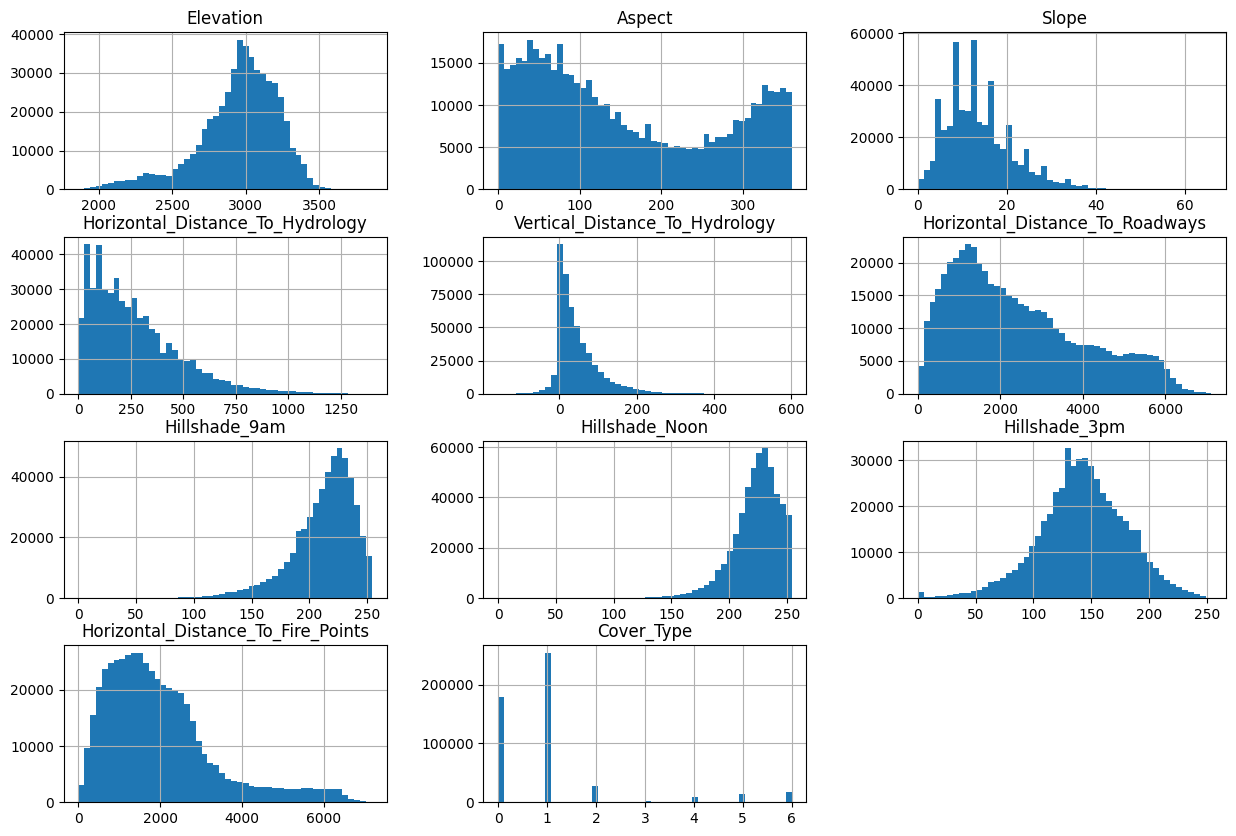

In [ ]:
# Гистограммы
numeric_nonbinary.hist(bins=50, figsize=(15, 10))
plt.show()

- Распределение Elevation показывает выраженный пик в диапазоне около 2800–3200 метров, что соответствует преобладанию участков на средней высоте. Значения ниже 2500 метров встречаются значительно реже, а максимальные высоты представлены ограниченно.

- Признак Aspect имеет распределение, близкое к равномерному по всей окружности от 0 до 360 градусов. Небольшие локальные колебания частот связаны с особенностями рельефа, но выраженных мод здесь нет, что характерно для направления склонов.

- Распределение Slope смещено влево: большая часть склонов имеет малый угол наклона, чаще всего 0–15 градусов. Крутые склоны встречаются значительно реже, что отражает природные особенности территории.

- Horizontal_Distance_To_Hydrology показывает быстро убывающее распределение: большинство участков расположено недалеко от водоёмов, и лишь небольшая часть — на расстояниях свыше 500 метров. Аналогичный характер наблюдается и у Vertical_Distance_To_Hydrology, где заметны отрицательные значения, указывающие на участки ниже уровня водного объекта.

- Horizontal_Distance_To_Roadways имеет более широкое распределение с пиком в диапазоне около 1000–2500 метров. При этом встречаются значительные значения вплоть до 7000 метров, что свидетельствует о сильно различающейся удалённости участков от дорог.

- Гистограммы Hillshade_9am и Hillshade_Noon имеют выраженные пики в диапазонах средних значений освещённости, что соответствует нормальным условиям освещения летом. В то же время Hillshade_3pm демонстрирует почти симметричное распределение с центром около 140–150, что характерно для дневной динамики освещённости.

- Горизонтальная дистанция до очагов пожаров (Horizontal_Distance_To_Fire_Points) также смещена влево: большая часть значений находится в пределах до 2000 метров, после чего частота снижается. Это отражает распределение пожарных точек в регионе.

- Целевой признак Cover_Type не является непрерывным и показывает семь чётко выраженных столбцов, соответствующих семи типам лесного покрова. Наиболее распространены типы 1 и 0, а типы 3 и 6 встречаются реже.

Распределения признаков выглядят ожидаемо для данных, характеризующих рельеф и природные условия территории. Смещённые влево распределения расстояний до водоёмов, дорог и точек пожаров отражают естественную географическую структуру района, где большая часть объектов расположена сравнительно близко к ключевым природным и инфраструктурным элементам. Особенности распределений освещённости также соответствуют естественным колебаниям солнечного освещения в течение дня. Равномерность распределения Aspect и выраженная доминанта средних значений Elevation не вызывают несоответствий. Наличие отрицательных значений вертикальной дистанции до гидрообъектов объясняется участками, расположенными ниже уровня воды, и также не является аномалией. В целом данные не демонстрируют признаков некорректности или искусственного ограничения значений, однако значительные различия в масштабах признаков указывают на необходимость дальнейшего масштабирования перед обучением моделей.

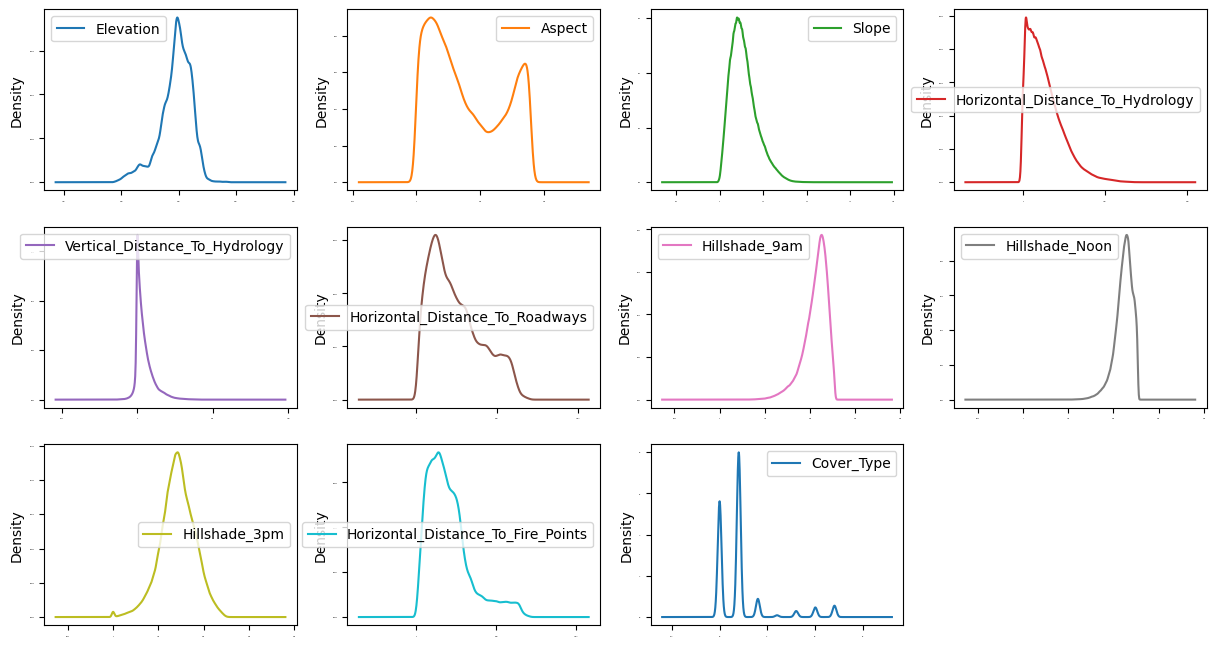

In [ ]:
# Графики плотности
numeric_nonbinary.plot(kind='density', subplots=True, layout=(3, 4), sharex=False, legend=True, fontsize=1, figsize=(15, 8))
plt.show()

Построенные графики плотности подтверждают выводы, сделанные по гистограммам.

Таким образом, графики плотности позволяют убедиться, что данные не содержат сильных искажений,
и могут быть использованы для дальнейшего построения моделей после масштабирования.

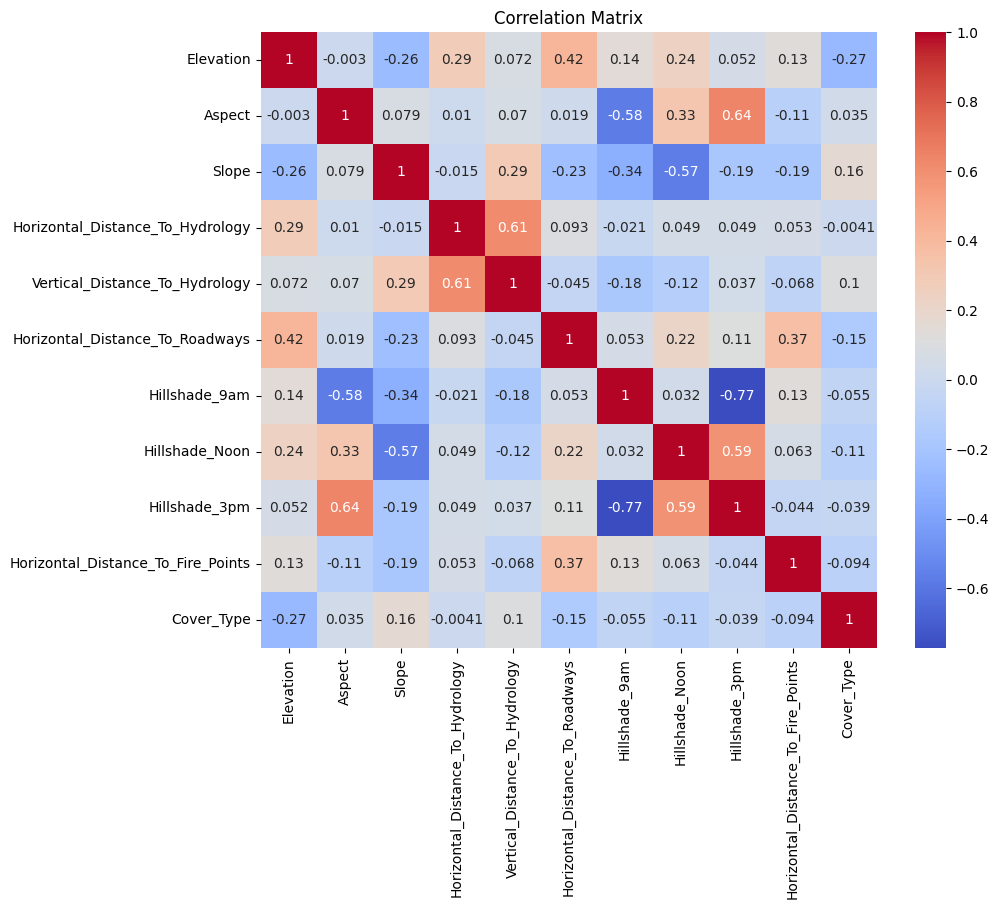

,Cover_Type
Cover_Type,1.000000
Wilderness_Area_3,0.348599
Soil_Type_9,0.252168
Soil_Type_37,0.170576
Slope,0.163752
Soil_Type_38,0.163077
Soil_Type_1,0.121361
Soil_Type_5,0.121226
Soil_Type_34,0.109878
Vertical_Distance_To_Hydrology,0.102207


In [ ]:
# Корреляционная матрица Пирсона
corr_matrix = df.corr()

# Тепловая карта со всеми признаками кроме бинарных
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix')
sns.heatmap(numeric_nonbinary.corr(), vmax=1, square=True, annot=True, cmap="coolwarm")
plt.show()

# Поиск корреляционной зависимости с целевым признаком
corr_matrix["Cover_Type"].sort_values(ascending=False)

Наибольшую по модулю связь с целевым признаком демонстрируют признаки, связанные с природно-географическим положением участка. Признак Wilderness_Area_3 имеет максимальную положительную корреляцию с Cover_Type (≈ 0.3486), что указывает на существенное влияние принадлежности участка к этой природной зоне на тип лесного покрова. Значимую положительную связь также показывает Soil_Type_9 (≈ 0.2522), отражая важность конкретного типа почвы для формирования определённых лесных сообществ. Среди отрицательных корреляций наиболее заметны Elevation (≈ –0.2707) и Wilderness_Area_0 (≈ –0.2401), что может быть связано с тем, что некоторые типы лесов чаще встречаются в низинных районах и в пределах определённых wilderness-зон.

В то же время значительная часть признаков имеет крайне слабую связь с целевой переменной. Например, такие признаки, как Soil_Type_15 (≈ –0.0009), Soil_Type_24 (≈ 0.0020), Soil_Type_25 (≈ –0.0005), Soil_Type_6 (≈ –0.0008) и другие бинарные индикаторы демонстрируют корреляции, близкие к нулю. Это означает, что в линейном выражении они практически не влияют на определение типа лесного покрова и могут быть полезны только в сочетании с другими признаками или в моделях, учитывающих нелинейные зависимости.

### 5. Эксперементы с комбинацией атрибутов

### Уклон к гидрологии (Slope_to_Hydrology)

Что отражает: Этот показатель характеризует крутизну склона по направлению к водным объектам. Он показывает, насколько быстро изменяется высота при движении к ближайшему водному источнику.

Экологическая значимость:
- Высокие значения указывают на крутые спуски к воде — это могут быть овраги, речные долины с резкими берегами
- Низкие значения характерны для равнинных участков с постепенным понижением к воде
- Влияет на дренаж почвы: крутые склоны быстрее отводят воду, пологие — способствуют заболачиванию
- Определяет доступность водных ресурсов для растительности

### Взаимодействие уклона и освещенности (Slope_To_Hillshade)

Что отражает: Эти признаки показывают, как уклон местности влияет на освещенность в разное время суток.

Экологическая значимость:
- Утренняя освещенность (`Slope_To_Hillshade9am`) критична для растений, чувствительных к первому солнечному свету
- Полуденная (`Slope_To_HillshadeNoon`) определяет максимальную инсоляцию в пик дня
- Вечерняя (`Slope_To_Hillshade3pm`) влияет на продолжительность светового дня
- Южные склоны с высокой освещенностью создают более теплые и сухие условия
- Северные склоны с низкой освещенностью — более влажные и прохладные

### Комплексная удаленность от воды (Hydrology_Horizontal_Vertical)

Что отражает: Интегральный показатель, объединяющий горизонтальную и вертикальную составляющие расстояния до воды.

Экологическая значимость:
- Высокие значения означают участки, сильно удаленные от воды как по плоскости, так и по высоте
- Низкие значения — близкое расположение к водным объектам
- Помогает идентифицировать:
  - Засушливые возвышенности (высокие значения)
  - Речные долины и низины (низкие значения)
  - Участки с высоким уровнем грунтовых вод

### Взаимодействие высоты и крутизны (Elevation_Slope_Interaction)

Что отражает: Комплексный показатель, характеризующий экстремальность рельефа.

Экологическая значимость:
- Высокие значения: крутые высокогорные склоны — экстремальные условия с:
  - Сильными ветрами
  - Быстрым дренажом
  - Ограниченным почвенным покровом
  - Специфической горной растительностью
- Низкие значения: равнинные участки или пологие склоны — стабильные условия
- Определяет зоны повышенной эрозии и оползневой опасности

### Общая ценность для классификации лесного покрова

Эти комбинированные атрибуты помогают нейросетевой модели выявлять сложные нелинейные зависимости, которые невозможно уловить при анализе отдельных признаков. Например:

- Сочетание крутого склона и высокой освещенности создает уникальные условия для pасухоустойчивоq растительности
- Высокогорные крутые склоны определяют распространение альпийских видов леса
- Взаимодействие рельефа и гидрологии формирует микроклимат, критически важный для определенных типов лесных сообществ

Именно такие комплексные показатели часто оказываются наиболее информативными для экологического моделирования, так как они лучше соответствуют реальным физическим процессам в природе.

In [ ]:
df_with_new_attributes = df.copy()

# Взаимодействие рельефа и освещенности
df_with_new_attributes['Slope_to_Hydrology'] = df_with_new_attributes['Vertical_Distance_To_Hydrology'] / (df_with_new_attributes['Horizontal_Distance_To_Hydrology'] + 0.001) # +0.001 чтобы избежать деления на 0

# Взаимодействие высоты и затенения
df_with_new_attributes['Slope_To_Hillshade9am'] = df_with_new_attributes['Slope'] * df_with_new_attributes['Hillshade_9am']
df_with_new_attributes['Slope_To_HillshadeNoon'] = df_with_new_attributes['Slope'] * df_with_new_attributes['Hillshade_Noon']
df_with_new_attributes['Slope_To_Hillshade3pm'] = df_with_new_attributes['Slope'] * df_with_new_attributes['Hillshade_3pm']

# Горизонтальное и вертикальное расстояние до воды
df_with_new_attributes['Hydrology_Horizontal_Vertical'] = df_with_new_attributes['Horizontal_Distance_To_Hydrology'] * df_with_new_attributes['Vertical_Distance_To_Hydrology']

# Взаимодействие высоты и уклона
df_with_new_attributes['Elevation_Slope_Interaction'] = df_with_new_attributes['Elevation'] * df_with_new_attributes['Slope']
# Поиск корреляционной зависимости с целевым признаком
pd.set_option('display.max_rows', None)
corr_matrix = df_with_new_attributes.corr()
corr_with_target = corr_matrix["Cover_Type"].sort_values(ascending=False)
print(corr_with_target)

Cover_Type                            1.000000
Wilderness_Area_3                     0.348599
Soil_Type_9                           0.252168
Soil_Type_37                          0.170576
Slope                                 0.163752
Soil_Type_38                          0.163077
Slope_to_Hydrology                    0.162024
Slope_To_Hillshade9am                 0.151685
Slope_To_HillshadeNoon                0.149287
Soil_Type_1                           0.121361
Soil_Type_5                           0.121226
Soil_Type_34                          0.109878
Slope_To_Hillshade3pm                 0.105863
Vertical_Distance_To_Hydrology        0.102207
Elevation_Slope_Interaction           0.100031
Soil_Type_0                           0.097510
Soil_Type_39                          0.091881
Soil_Type_16                          0.089422
Soil_Type_36                          0.086384
Soil_Type_3                           0.085740
Soil_Type_4                           0.083659
Soil_Type_2  

Среди добавленных признаков наибольшую по модулю корреляцию с целевым признаком демонстрируют Slope_to_Hydrology и Slope_To_Hillshade9am, значения которых достигают уровня примерно 0.16. Эти признаки отражают особенности рельефа и его влияние на освещённость и удалённость от водоёмов, что логично связано с распределением типов лесного покрова. Несколько ниже, но всё же заметно связаны с целевой переменной признаки Slope_To_HillshadeNoon, Slope_To_Hillshade3pm и Elevation_Slope_Interaction, что также подтверждает важность рельефных характеристик.

Интегральный показатель расстояния до водоёмов Hydrology_Horizontal_Vertical имеет корреляцию порядка 0.07 и демонстрирует слабую линейную зависимость. Это указывает на то, что пространственная удалённость от воды влияет на тип лесного покрова лишь частично.

В целом новые признаки проявляют слабые, но ожидаемые по смыслу корреляции: показатели, связанные с уклоном, высотой и освещённостью, оказываются наиболее информативными, тогда как интегральные расстояния до воды имеют меньшее влияние. Такие результаты характерны для экологических и географических данных, где значимые зависимости чаще проявляются в нелинейном виде и требуют применения более сложных моделей для полного извлечения информации.

###Отбор лучших признаков

In [ ]:
corr_with_target_abs = abs(corr_matrix["Cover_Type"]).sort_values(ascending=False)
print("Топ-25 признаков по абсолютной корреляции:")
print(corr_with_target_abs.head(25))

Топ-25 признаков по абсолютной корреляции:
Cover_Type                            1.000000
Wilderness_Area_3                     0.348599
Elevation                             0.270652
Soil_Type_9                           0.252168
Wilderness_Area_0                     0.240075
Soil_Type_37                          0.170576
Slope                                 0.163752
Soil_Type_38                          0.163077
Slope_to_Hydrology                    0.162024
Horizontal_Distance_To_Roadways       0.153851
Slope_To_Hillshade9am                 0.151685
Slope_To_HillshadeNoon                0.149287
Soil_Type_28                          0.139942
Soil_Type_22                          0.133698
Soil_Type_21                          0.132213
Soil_Type_1                           0.121361
Soil_Type_5                           0.121226
Soil_Type_34                          0.109878
Slope_To_Hillshade3pm                 0.105863
Hillshade_Noon                        0.105208
Vertical_Distance

На первом плане оказываются фундаментальные географические и топографические характеристики. Признаки природных зон Wilderness_Area демонстрируют исключительную значимость, причем Wilderness_Area_3 имеет самую высокую корреляцию среди всех, а Wilderness_Area_0 занимает третье место. Это ясно указывает на то, что макролокация и принадлежность к крупным природным зонам является первичным фактором в распределении типов леса. Не менее важной оказывается высота над уровнем моря - Elevation занимает вторую позицию в рейтинге, что подчеркивает критическую роль вертикальной зональности в формировании растительности.

Особого внимания заслуживает успех созданных признаков. Комбинация Slope_to_Hydrology, отражающая комплексную доступность водных ресурсов, заняла высокое 9-е место, обогнав многие исходные параметры. Признаки взаимодействия рельефа и освещенности Slope_To_Hillshade также показали отличные результаты, попав в топ-20.

Среди почвенных характеристик наблюдается выраженная избирательность влияния. Всего несколько типов почв вошли в число высококоррелированных признаков, причем Soil_Type_9 демонстрирует особенно сильную связь, занимая четвертое место. Однако большинство почвенных индикаторов имеют умеренную или слабую корреляцию, что, вероятно, только определенные типы субстрата играют ключевую роль в разделении лесных покровов, в то время как другие могут быть второстепенными или проявлять свое влияние только в сочетании с другими факторами.

Инфраструктурные и антропогенные факторы также оказывают заметное влияние. Расстояние до дорог оказалось в топ-10 наиболее коррелированных признаков, что указывает на ощутимое влияние транспортной доступности на характер растительности. Расстояние до точек возгорания, хотя и с меньшим коэффициентом, также вошло в топ-25, отражая роль пожарного режима в формировании лесных экосистем.

Параметры света представлены в основном через созданные комбинированные признаки, в то время как исходные показатели освещенности имеют относительно скромное влияние. Это подтверждает, что именно взаимодействие освещенности с рельефом, а не абсолютные значения затенения, несет наибольшую прогностическую ценность для классификации типов леса.

###6. Очистка данных и отбор существенных(информативных) признаков

По результатам разведочного анализа и корреляционного исследования было принято решение оставить 25 лучших атрибутов, которые были определены в разделе выше.

In [ ]:
selected_columns = [
    'Cover_Type',
    'Wilderness_Area_3',
    'Elevation',
    'Soil_Type_9',
    'Wilderness_Area_0',
    'Soil_Type_37',
    'Slope',
    'Soil_Type_38',
    'Slope_to_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Slope_To_Hillshade9am',
    'Slope_To_HillshadeNoon',
    'Soil_Type_28',
    'Soil_Type_22',
    'Soil_Type_21',
    'Soil_Type_1',
    'Soil_Type_5',
    'Soil_Type_34',
    'Slope_To_Hillshade3pm',
    'Hillshade_Noon',
    'Vertical_Distance_To_Hydrology',
    'Elevation_Slope_Interaction',
    'Soil_Type_0',
    'Horizontal_Distance_To_Fire_Points',
    'Soil_Type_39'
]

# Создаем новый датасет только с выбранными столбцами
df_significant = df_with_new_attributes[selected_columns]

# Проверяем результат
print(f"Размер нового датасета: {df_significant.shape}")
print(f"Количество samples: {df_significant.shape[0]}")

Размер нового датасета: (505354, 25)
Количество samples: 505354


In [ ]:
# Проверка структуры итогового набора данных
df.info()

df_original = df.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505354 entries, 0 to 505353
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           505354 non-null  float64
 1   Aspect                              505354 non-null  float64
 2   Slope                               505354 non-null  float64
 3   Horizontal_Distance_To_Hydrology    505354 non-null  float64
 4   Vertical_Distance_To_Hydrology      505354 non-null  float64
 5   Horizontal_Distance_To_Roadways     505354 non-null  float64
 6   Hillshade_9am                       505354 non-null  float64
 7   Hillshade_Noon                      505354 non-null  float64
 8   Hillshade_3pm                       505354 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  505354 non-null  float64
 10  Wilderness_Area_0                   505354 non-null  float64
 11  Wilderness_Area_1         

###7. Преобразование данных (Нормализация)


In [ ]:
# Отделяем признаки от целевой переменной ПЕРЕД нормализацией
X_original = df_original.drop('Cover_Type', axis=1)
y_original = df_original['Cover_Type']

X_significant = df_significant.drop('Cover_Type', axis=1)
y_significant = df_significant['Cover_Type']

# Нормализуем только признаки
scaler = Normalizer()
X_original_normalized = pd.DataFrame(
    scaler.fit_transform(X_original),
    columns=X_original.columns,
    index=X_original.index
)

X_significant_normalized = pd.DataFrame(
    scaler.fit_transform(X_significant),
    columns=X_significant.columns,
    index=X_significant.index
)

# Возвращаем целевую переменную
df_original_normalized = pd.concat([X_original_normalized, y_original], axis=1)
df_significant_normalized = pd.concat([X_significant_normalized, y_significant], axis=1)
df_original_normalized.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,0.380210,0.007469,0.000439,0.037787,0.000000,0.074695,0.032368,0.033979,0.021676,0.919622,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,0.382769,0.008276,0.000296,0.031331,-0.000887,0.057637,0.032513,0.034730,0.022316,0.919975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.375821,0.018630,0.001206,0.035920,0.008712,0.426216,0.031363,0.031899,0.018094,0.820399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.371810,0.020693,0.002403,0.032308,0.015754,0.412529,0.031774,0.031774,0.016288,0.829196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.386275,0.006698,0.000298,0.022775,-0.000149,0.058202,0.032748,0.034832,0.022328,0.918725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


###8. Разделение набора данных на обучающий и тестовый наборы

In [ ]:
# УСТАНОВКА RANDOM SEED ДЛЯ ВОСПРОИЗВОДИМОСТИ
SEED = 21

set_random_seed(SEED)

In [ ]:
# Исходные данные
X_original = df_original.drop(columns=["Cover_Type"])
y_original = df_original["Cover_Type"]

# Деление на обучающую и тестовую выборки
X_train_full_original, X_test_original, y_train_full_original, y_test_original = train_test_split(
    X_original, y_original, test_size=0.2, random_state=7
)

# Деление обучающей выборки на train и validation
X_train_original, X_val_original, y_train_original, y_val_original = train_test_split(
    X_train_full_original, y_train_full_original, test_size=0.25, random_state=7
)

# Проверка размеров наборов
len(X_train_original), len(X_val_original), len(X_test_original)

(303212, 101071, 101071)

In [ ]:
# Преобразованные данные
X_converted = df_original_normalized.drop(columns=["Cover_Type"])
y_converted = df_original_normalized["Cover_Type"]

# Деление на обучающую и тестовую выборки
X_train_full_converted, X_test_converted, y_train_full_converted, y_test_converted = train_test_split(
    X_converted, y_converted, test_size=0.2, random_state=7
)

# Деление обучающей выборки на train и validation
X_train_converted, X_val_converted, y_train_converted, y_val_converted = train_test_split(
    X_train_full_converted, y_train_full_converted, test_size=0.25, random_state=7
)

# Проверка размеров наборов
len(X_train_converted), len(X_val_converted), len(X_test_converted)

(303212, 101071, 101071)

In [ ]:
# Построенный набор данных
df_constructed = df_significant.copy()

X_constructed = df_constructed.drop(columns=["Cover_Type"])
y_constructed = df_constructed["Cover_Type"]

# Деление на обучающую и тестовую выборки
X_train_full_constructed, X_test_constructed, y_train_full_constructed, y_test_constructed = train_test_split(
    X_constructed, y_constructed, test_size=0.2, random_state=7
)

# Деление обучающей выборки на train и validation
X_train_constructed, X_val_constructed, y_train_constructed, y_val_constructed = train_test_split(
    X_train_full_constructed, y_train_full_constructed, test_size=0.25, random_state=7
)

# Проверка размеров наборов
len(X_train_constructed), len(X_val_constructed), len(X_test_constructed)

(303212, 101071, 101071)

In [ ]:
# Преобразованный построенный набор данных
df_constructed_scaled = df_significant_normalized.copy()

X_constructed_scaled = df_constructed_scaled.drop(columns=["Cover_Type"])
y_constructed_scaled = df_constructed_scaled["Cover_Type"]

# Деление на обучающую и тестовую выборки
X_train_full_constructed_scaled, X_test_constructed_scaled, y_train_full_constructed_scaled, y_test_constructed_scaled = train_test_split(
    X_constructed_scaled, y_constructed_scaled, test_size=0.2, random_state=7
)

# Деление обучающей выборки на train и validation
X_train_constructed_scaled, X_val_constructed_scaled, y_train_constructed_scaled, y_val_constructed_scaled = train_test_split(
    X_train_full_constructed_scaled, y_train_full_constructed_scaled, test_size=0.25, random_state=7
)

# Проверка размеров наборов
len(X_train_constructed_scaled), len(X_val_constructed_scaled), len(X_test_constructed_scaled)

(303212, 101071, 101071)

### 9. Качество полносвязной нейросетевой регрессионной модели и LSTM регрессионной нейросетевой модели

In [ ]:
# Функция для проверки сбалансированности классов
def check_class_balance(y, dataset_name=""):
    class_counts = pd.Series(y).value_counts().sort_index()
    print(f"Распределение классов {dataset_name}:")
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"  Коэффициент дисбаланса: {imbalance_ratio:.2f}")
    return imbalance_ratio > 2


# Функция для расчета метрик классификации
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, balanced_acc, f1


# Callbacks
early_stopping_patience = 15
plateau_lr_reduce_factor = 0.25
plateau_patience = 10

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=early_stopping_patience,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=plateau_lr_reduce_factor,
        patience=plateau_patience,
        min_lr=1e-7
    )
]


# Создание моделей
def create_dense_model(input_dim, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def create_lstm_model(input_dim, num_classes):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=(1, input_dim)),
        Dropout(0.3),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Словари
results = {'dense': {}, 'lstm': {}}
all_models = {'dense': {}, 'lstm': {}}

datasets = {
    'original': (X_train_original, X_val_original, y_train_original, y_val_original),
    'converted': (X_train_converted, X_val_converted, y_train_converted, y_val_converted),
    'constructed': (X_train_constructed, X_val_constructed, y_train_constructed, y_val_constructed),
    'constructed_scaled': (X_train_constructed_scaled, X_val_constructed_scaled,
                           y_train_constructed_scaled, y_val_constructed_scaled)
}

# Количество классов (0-6)
num_classes = len(np.unique(y_train_original))

# Проверка баланса
print("\n" + "="*60)
print("ПРОВЕРКА СБАЛАНСИРОВАННОСТИ КЛАССОВ ВО ВСЕХ ВЫБОРКАХ")
print("="*60)

is_imbalanced_overall = False
for dataset_name, (X_train, X_val, y_train, y_val) in datasets.items():
    print(f"\nНабор данных: {dataset_name}")
    print("-" * 40)

    imbalanced_train = check_class_balance(y_train, f"Train ({dataset_name})")
    imbalanced_val = check_class_balance(y_val, f"Validation ({dataset_name})")

    if imbalanced_train or imbalanced_val:
        is_imbalanced_overall = True

print(f"\n{'='*60}")
print(f"ОБЩИЙ ВЫВОД: данные {'НЕСБАЛАНСИРОВАНЫ' if is_imbalanced_overall else 'СБАЛАНСИРОВАНЫ'}")
print("="*60)


# Обучение моделей
for dataset_name, (X_train, X_val, y_train, y_val) in datasets.items():
    print(f"\n{'='*50}")
    print(f"Обработка набора данных: {dataset_name}")
    print(f"{'='*50}")

    input_dim = X_train.shape[1]

    # Dense
    print("Обучение полносвязной модели...")
    dense_model = create_dense_model(input_dim, num_classes)

    history_dense = dense_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )

    y_train_pred_dense = dense_model.predict(X_train, verbose=0).argmax(axis=1)
    y_val_pred_dense = dense_model.predict(X_val, verbose=0).argmax(axis=1)

    train_acc_d, train_bal_d, train_f1_d = calculate_metrics(y_train, y_train_pred_dense)
    val_acc_d, val_bal_d, val_f1_d = calculate_metrics(y_val, y_val_pred_dense)

    results['dense'][dataset_name] = {
        'train_accuracy': train_acc_d,
        'train_balanced_accuracy': train_bal_d,
        'train_f1': train_f1_d,
        'val_accuracy': val_acc_d,
        'val_balanced_accuracy': val_bal_d,
        'val_f1': val_f1_d
    }

    all_models['dense'][dataset_name] = dense_model

    # LSTM
    print("Обучение LSTM модели...")
    lstm_model = create_lstm_model(input_dim, num_classes)

    X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val_lstm = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))

    history_lstm = lstm_model.fit(
        X_train_lstm, y_train,
        validation_data=(X_val_lstm, y_val),
        epochs=20,
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )

    y_train_pred_lstm = lstm_model.predict(X_train_lstm, verbose=0).argmax(axis=1)
    y_val_pred_lstm = lstm_model.predict(X_val_lstm, verbose=0).argmax(axis=1)

    train_acc_l, train_bal_l, train_f1_l = calculate_metrics(y_train, y_train_pred_lstm)
    val_acc_l, val_bal_l, val_f1_l = calculate_metrics(y_val, y_val_pred_lstm)

    results['lstm'][dataset_name] = {
        'train_accuracy': train_acc_l,
        'train_balanced_accuracy': train_bal_l,
        'train_f1': train_f1_l,
        'val_accuracy': val_acc_l,
        'val_balanced_accuracy': val_bal_l,
        'val_f1': val_f1_l
    }

    all_models['lstm'][dataset_name] = lstm_model

    print(f"\nРезультаты для {dataset_name}:")
    print("Полносвязная модель:")
    print(f"  Train Accuracy: {train_acc_d:.4f}, Balanced: {train_bal_d:.4f}, F1: {train_f1_d:.4f}")
    print(f"  Val Accuracy:   {val_acc_d:.4f}, Balanced: {val_bal_d:.4f}, F1: {val_f1_d:.4f}")

    print("LSTM модель:")
    print(f"  Train Accuracy: {train_acc_l:.4f}, Balanced: {train_bal_l:.4f}, F1: {train_f1_l:.4f}")
    print(f"  Val Accuracy:   {val_acc_l:.4f}, Balanced: {val_bal_l:.4f}, F1: {val_f1_l:.4f}")


# Сводная таблица
def create_results_summary(results):
    summary = []
    for model_type in ['dense', 'lstm']:
        for dataset_name in datasets.keys():
            m = results[model_type][dataset_name]
            summary.append({
                'Model': model_type.upper(),
                'Dataset': dataset_name,
                'Train_Accuracy': m['train_accuracy'],
                'Val_Accuracy': m['val_accuracy'],
                'Train_Balanced_Accuracy': m['train_balanced_accuracy'],
                'Val_Balanced_Accuracy': m['val_balanced_accuracy'],
                'Train_F1': m['train_f1'],
                'Val_F1': m['val_f1']
            })
    return pd.DataFrame(summary)

print("\n" + "="*80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("="*80)
print(create_results_summary(results).round(4))


# Анализ разницы
print("\n" + "="*80)
print("АНАЛИЗ РАЗНИЦЫ МЕЖДУ ACCURACY И BALANCED_ACCURACY")
print("="*80)

for model_type in ['dense', 'lstm']:
    print(f"\n{model_type.upper()} модели:")
    for dataset_name in datasets.keys():
        m = results[model_type][dataset_name]
        diff = abs(m['val_accuracy'] - m['val_balanced_accuracy'])
        print(f"  {dataset_name}: diff = {diff:.4f}")


# Функция визуализации
def plot_comparison(results, metric, title):
    plt.figure(figsize=(12, 6))

    ds = list(datasets.keys())
    dense_train = [results['dense'][d][f'train_{metric}'] for d in ds]
    dense_val = [results['dense'][d][f'val_{metric}'] for d in ds]
    lstm_train = [results['lstm'][d][f'train_{metric}'] for d in ds]
    lstm_val = [results['lstm'][d][f'val_{metric}'] for d in ds]

    x = np.arange(len(ds))
    width = 0.2

    plt.bar(x - width*1.5, dense_train, width, label='Dense Train', alpha=0.7)
    plt.bar(x - width*0.5, dense_val, width, label='Dense Val', alpha=0.7)
    plt.bar(x + width*0.5, lstm_train, width, label='LSTM Train', alpha=0.7)
    plt.bar(x + width*1.5, lstm_val, width, label='LSTM Val', alpha=0.7)

    plt.xlabel('Наборы данных')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(title)
    plt.xticks(x, ds, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


ПРОВЕРКА СБАЛАНСИРОВАННОСТИ КЛАССОВ ВО ВСЕХ ВЫБОРКАХ

Набор данных: original
----------------------------------------
Распределение классов Train (original):
  Коэффициент дисбаланса: 93.51
Распределение классов Validation (original):
  Коэффициент дисбаланса: 92.28

Набор данных: converted
----------------------------------------
Распределение классов Train (converted):
  Коэффициент дисбаланса: 93.51
Распределение классов Validation (converted):
  Коэффициент дисбаланса: 92.28

Набор данных: constructed
----------------------------------------
Распределение классов Train (constructed):
  Коэффициент дисбаланса: 93.51
Распределение классов Validation (constructed):
  Коэффициент дисбаланса: 92.28

Набор данных: constructed_scaled
----------------------------------------
Распределение классов Train (constructed_scaled):
  Коэффициент дисбаланса: 93.51
Распределение классов Validation (constructed_scaled):
  Коэффициент дисбаланса: 92.28

ОБЩИЙ ВЫВОД: данные НЕСБАЛАНСИРОВАНЫ

Обработка

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Обучение LSTM модели...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Результаты для original:
Полносвязная модель:
  Train Accuracy: 0.5027, Balanced: 0.1429, F1: 0.3363
  Val Accuracy:   0.5040, Balanced: 0.1429, F1: 0.3378
LSTM модель:
  Train Accuracy: 0.5645, Balanced: 0.2483, F1: 0.4464
  Val Accuracy:   0.5654, Balanced: 0.2486, F1: 0.4472

Обработка набора данных: converted
Обучение полносвязной модели...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Обучение LSTM модели...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Результаты для converted:
Полносвязная модель:
  Train Accuracy: 0.7767, Balanced: 0.6208, F1: 0.7696
  Val Accuracy:   0.7751, Balanced: 0.6104, F1: 0.7679
LSTM модель:
  Train Accuracy: 0.7369, Balanced: 0.4679, F1: 0.7200
  Val Accuracy:   0.7376, Balanced: 0.4695, F1: 0.7210

Обработка набора данных: constructed
Обучение полносвязной модели...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Обучение LSTM модели...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Результаты для constructed:
Полносвязная модель:
  Train Accuracy: 0.5027, Balanced: 0.1429, F1: 0.3363
  Val Accuracy:   0.5040, Balanced: 0.1429, F1: 0.3378
LSTM модель:
  Train Accuracy: 0.5027, Balanced: 0.1429, F1: 0.3363
  Val Accuracy:   0.5040, Balanced: 0.1429, F1: 0.3378

Обработка набора данных: constructed_scaled
Обучение полносвязной модели...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Обучение LSTM модели...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Результаты для constructed_scaled:
Полносвязная модель:
  Train Accuracy: 0.7270, Balanced: 0.4387, F1: 0.7083
  Val Accuracy:   0.7256, Balanced: 0.4371, F1: 0.7070
LSTM модель:
  Train Accuracy: 0.7072, Balanced: 0.3481, F1: 0.6787
  Val Accuracy:   0.7063, Balanced: 0.3457, F1: 0.6778

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
   Model             Dataset  Train_Accuracy  Val_Accuracy  \
0  DENSE            original          0.5027        0.5040   
1  DENSE           converted          0.7767        0.7751   
2  DENSE         constructed          0.5027        0.5040   
3  DENSE  constructed_scaled          0.7270        0.7256   
4   LSTM            original          0.5645        0.5654   
5   LSTM           converted          0.7369        0.7376   
6   LSTM         constructed          0.5027        0.5040   
7   LSTM  constructed_scaled          0.7072        0.7063   

   Train_Balanced_Accuracy  Val_Balanced_Accuracy  Train_F1  Val_F1  
0                   0.1429                 0.1429   

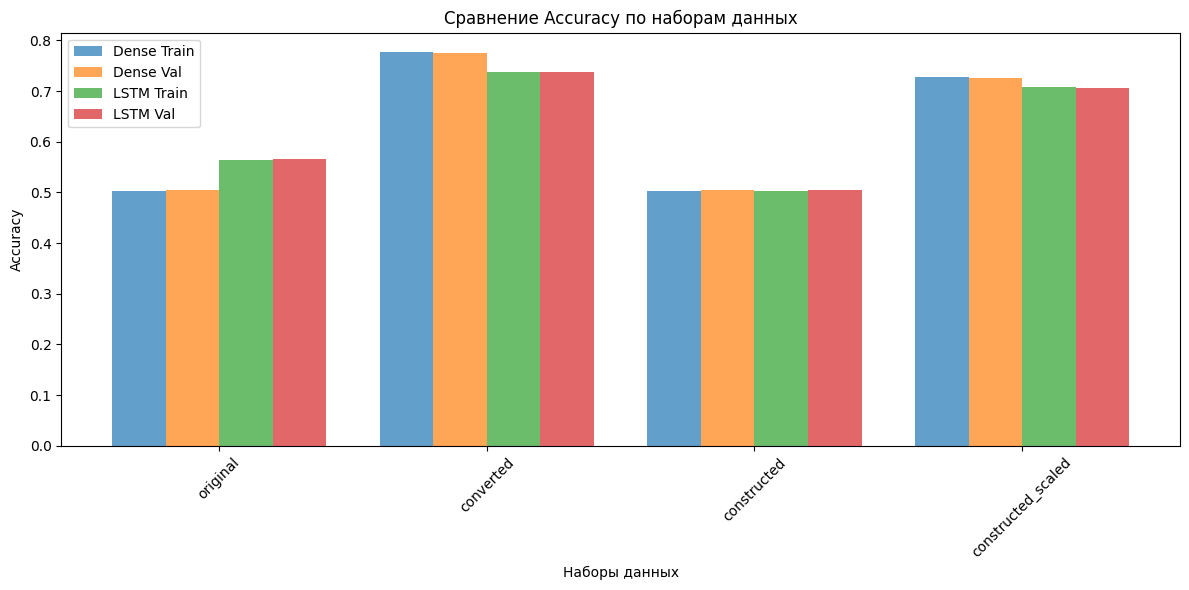

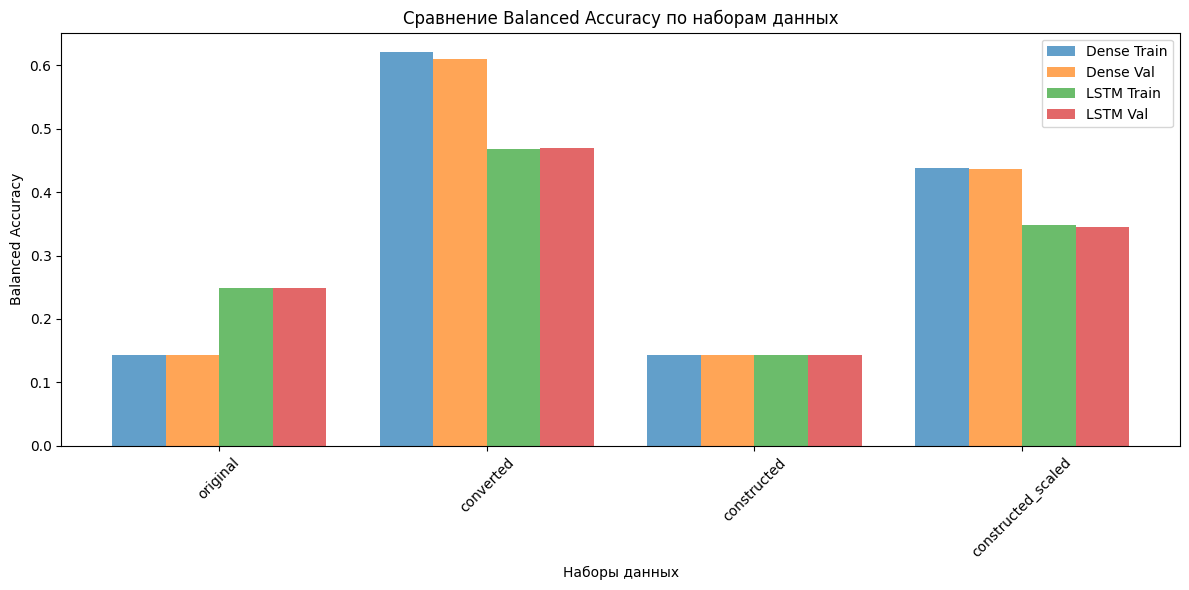

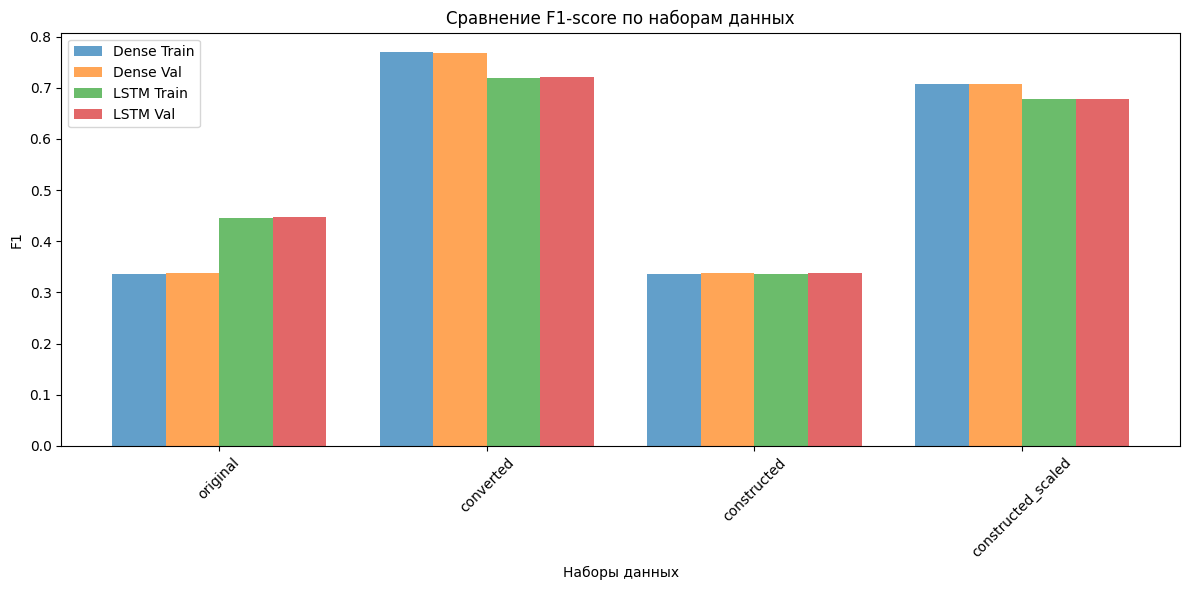

In [ ]:
# Визуализация метрик
plot_comparison(results, 'accuracy', 'Сравнение Accuracy по наборам данных')
plot_comparison(results, 'balanced_accuracy', 'Сравнение Balanced Accuracy по наборам данных')
plot_comparison(results, 'f1', 'Сравнение F1-score по наборам данных')

In [ ]:
# таблица результатов
# Создание сводной таблицы результатов
print("\n" + "="*100)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ - КЛАССИФИКАЦИЯ")
print("="*100)

for dataset_name in datasets.keys():
    print(f"\n{dataset_name.upper()}:")
    print("-" * 100)

    dense_results = results['dense'][dataset_name]
    lstm_results = results['lstm'][dataset_name]

    # Шапка таблицы
    print(f"{'':<20} {'DENSE NETWORK':^36} {'LSTM NETWORK':^36}")
    print(f"{'Метрика':<20} {'Train':>12} {'Val':>12} {'Train':>12} {'Val':>12}")
    print("-" * 100)

    # Accuracy
    print(f"{'Accuracy':<20} {dense_results['train_accuracy']:>12.4f} {dense_results['val_accuracy']:>12.4f} "
          f"{lstm_results['train_accuracy']:>12.4f} {lstm_results['val_accuracy']:>12.4f}")

    # Balanced Accuracy
    print(f"{'Balanced Acc':<20} {dense_results['train_balanced_accuracy']:>12.4f} {dense_results['val_balanced_accuracy']:>12.4f} "
          f"{lstm_results['train_balanced_accuracy']:>12.4f} {lstm_results['val_balanced_accuracy']:>12.4f}")

    # F1-score
    print(f"{'F1-score':<20} {dense_results['train_f1']:>12.4f} {dense_results['val_f1']:>12.4f} "
          f"{lstm_results['train_f1']:>12.4f} {lstm_results['val_f1']:>12.4f}")

print("\n" + "="*100)
print("ЛУЧШИЕ РЕЗУЛЬТАТЫ ПО ВАЛИДАЦИОННОЙ ВЫБОРКЕ")
print("="*100)

# Находим лучшие результаты для каждого набора данных
best_results = []
for dataset_name in datasets.keys():
    dense_val_acc = results['dense'][dataset_name]['val_accuracy']
    lstm_val_acc = results['lstm'][dataset_name]['val_accuracy']

    if dense_val_acc > lstm_val_acc:
        best_model = 'DENSE'
        best_accuracy = dense_val_acc
        best_balanced = results['dense'][dataset_name]['val_balanced_accuracy']
        best_f1 = results['dense'][dataset_name]['val_f1']
    else:
        best_model = 'LSTM'
        best_accuracy = lstm_val_acc
        best_balanced = results['lstm'][dataset_name]['val_balanced_accuracy']
        best_f1 = results['lstm'][dataset_name]['val_f1']

    best_results.append({
        'Dataset': dataset_name,
        'Best Model': best_model,
        'Accuracy': best_accuracy,
        'Balanced Acc': best_balanced,
        'F1-score': best_f1
    })

# Вывод таблицы лучших результатов
print(f"{'Dataset':<20} {'Best Model':<12} {'Accuracy':>10} {'Balanced Acc':>14} {'F1-score':>12}")
print("-" * 70)
for result in best_results:
    print(f"{result['Dataset']:<20} {result['Best Model']:<12} {result['Accuracy']:>10.4f} "
          f"{result['Balanced Acc']:>14.4f} {result['F1-score']:>12.4f}")



СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ - КЛАССИФИКАЦИЯ

ORIGINAL:
----------------------------------------------------------------------------------------------------
                                DENSE NETWORK                         LSTM NETWORK            
Метрика                     Train          Val        Train          Val
----------------------------------------------------------------------------------------------------
Accuracy                   0.5027       0.5040       0.5645       0.5654
Balanced Acc               0.1429       0.1429       0.2483       0.2486
F1-score                   0.3363       0.3378       0.4464       0.4472

CONVERTED:
----------------------------------------------------------------------------------------------------
                                DENSE NETWORK                         LSTM NETWORK            
Метрика                     Train          Val        Train          Val
--------------------------------------------------------------------------

Accuracy

Наивысшая точность достигнута на нормализованном оригинальном наборе данных (converted) при использовании полносвязной модели. Значение валидационной Accuracy составляет 0.7751, что является лучшим результатом среди всех экспериментов. LSTM показывает близкие, но более низкие значения (0.7376). Другие наборы данных заметно уступают.

Balanced Accuracy

Наиболее высокий показатель balanced accuracy также зафиксирован для нормализованного оригинального набора данных (converted) в сочетании с полносвязной моделью. Balanced Accuracy достигает 0.6104, что указывает на более устойчивое качество предсказаний для несбалансированных классов по сравнению с остальными конфигурациями. LSTM на тех же данных показывает значительно более низкий результат — 0.4695.

F1-score

Максимальный F1-score наблюдается снова на нормализованном оригинальном наборе (converted) для полносвязной сети, где значение F1 составляет 0.7679. LSTM-модель на этих данных даёт несколько меньший показатель — 0.7210. Остальные наборы данных формируют более низкие значения F1, включая constructed и constructed_scaled.

Общий вывод

Все три метрики — Accuracy, Balanced Accuracy и F1 — стабильно показывают лучшие результаты при использовании нормализованного оригинального набора данных (converted) и полносвязной нейросетевой модели. Эта конфигурация обеспечивает наиболее полный и устойчивый баланс качества, что делает её предпочтительным вариантом для задачи классификации типов лесного покрова.

###10. Оценка качества

In [ ]:
# Оценка на лучшей модели
best_model = all_models['dense']['converted']

print("=" * 70)
print("ОЦЕНКА КАЧЕСТВА ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("=" * 70)
print("Лучшая модель: DENSE (полносвязная) сеть")
print("Лучший набор данных: CONVERTED")
print("=" * 70)

X_test_dense = X_test_converted
X_train_dense = X_train_converted
X_val_dense = X_val_converted

print("\nОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
y_test_pred = best_model.predict(X_test_dense, verbose=0).argmax(axis=1)

# → ВАЖНО: y_test_converted уже содержит классы 0–6 (если вы вычитали 1 ДО разбиения)
test_accuracy, test_balanced, test_f1 = calculate_metrics(y_test_converted, y_test_pred)

# Метрики обучения
dense_results = results['dense']['converted']
train_accuracy, train_balanced, train_f1 = (
    dense_results['train_accuracy'],
    dense_results['train_balanced_accuracy'],
    dense_results['train_f1']
)
val_accuracy, val_balanced, val_f1 = (
    dense_results['val_accuracy'],
    dense_results['val_balanced_accuracy'],
    dense_results['val_f1']
)

print("\n" + "=" * 70)
print("РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ - КЛАССИФИКАЦИЯ")
print("=" * 70)
print(f"{'Метрика':<20} | {'Train':<10} | {'Validation':<12} | {'Test':<10}")
print("-" * 65)
print(f"{'Accuracy':<20} | {train_accuracy:10.4f} | {val_accuracy:12.4f} | {test_accuracy:10.4f}")
print(f"{'Balanced Accuracy':<20} | {train_balanced:10.4f} | {val_balanced:12.4f} | {test_balanced:10.4f}")
print(f"{'F1-score':<20} | {train_f1:10.4f} | {val_f1:12.4f} | {test_f1:10.4f}")

test_acc_diff = abs(test_accuracy - test_balanced)
print(f"\nРазница между Accuracy и Balanced Accuracy на тесте: {test_acc_diff:.4f}")
if test_acc_diff > 0.05:
    print("!  Заметный дисбаланс в данных")
else:
    print("✓  Данные достаточно сбалансированы")

ОЦЕНКА КАЧЕСТВА ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ
Лучшая модель: DENSE (полносвязная) сеть
Лучший набор данных: CONVERTED

ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ

РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ - КЛАССИФИКАЦИЯ
Метрика              | Train      | Validation   | Test      
-----------------------------------------------------------------
Accuracy             |     0.7767 |       0.7751 |     0.7750
Balanced Accuracy    |     0.6208 |       0.6104 |     0.6112
F1-score             |     0.7696 |       0.7679 |     0.7676

Разница между Accuracy и Balanced Accuracy на тесте: 0.1639
!  Заметный дисбаланс в данных


Вывод

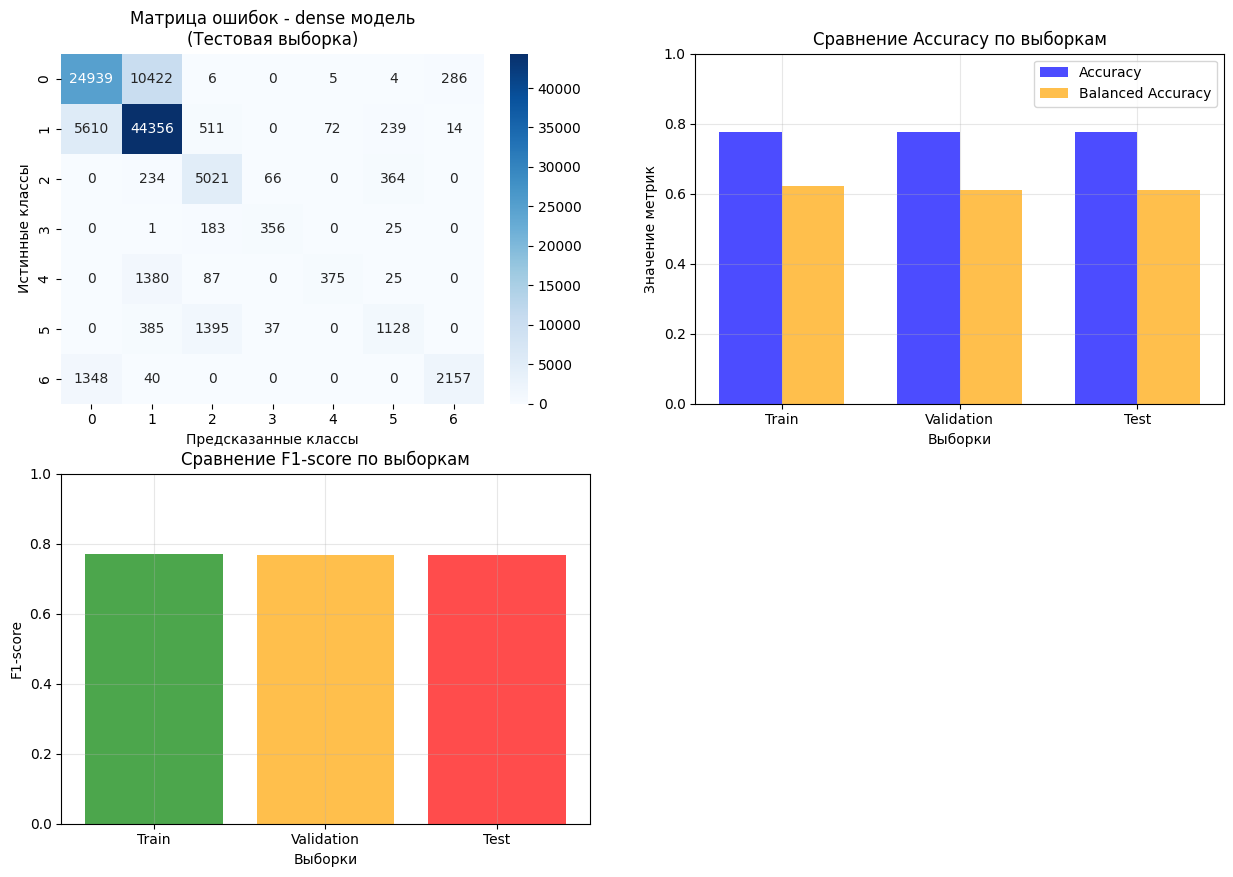

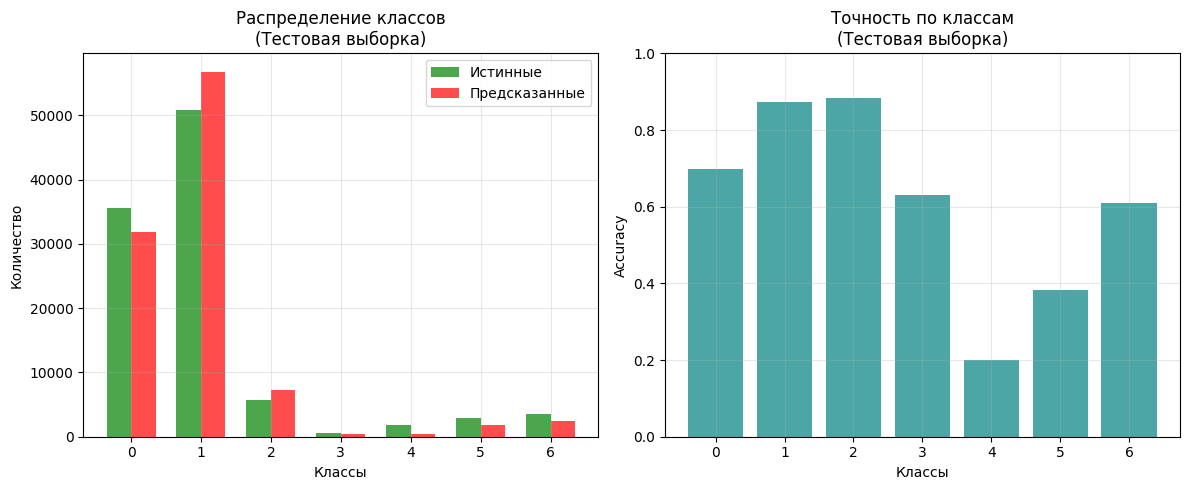

In [ ]:
#График
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Визуализация результатов классификации
plt.figure(figsize=(15, 10))

# График 1: Матрица ошибок (Confusion Matrix)
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test_converted, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_classes),
            yticklabels=range(num_classes))
plt.title('Матрица ошибок - dense модель\n(Тестовая выборка)')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')

# График 2: Сравнение Accuracy по выборкам
plt.subplot(2, 2, 2)
metrics_labels = ['Train', 'Validation', 'Test']
accuracy_values = [train_accuracy, val_accuracy, test_accuracy]
balanced_accuracy_values = [train_balanced, val_balanced, test_balanced]

x = np.arange(len(metrics_labels))
width = 0.35

plt.bar(x - width/2, accuracy_values, width, label='Accuracy', alpha=0.7, color='blue')
plt.bar(x + width/2, balanced_accuracy_values, width, label='Balanced Accuracy', alpha=0.7, color='orange')

plt.xlabel('Выборки')
plt.ylabel('Значение метрик')
plt.title('Сравнение Accuracy по выборкам')
plt.xticks(x, metrics_labels)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# График 3: Сравнение F1-score по выборкам
plt.subplot(2, 2, 3)
f1_values = [train_f1, val_f1, test_f1]

plt.bar(metrics_labels, f1_values, color=['green', 'orange', 'red'], alpha=0.7)
plt.xlabel('Выборки')
plt.ylabel('F1-score')
plt.title('Сравнение F1-score по выборкам')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)


# Дополнительная визуализация: распределение классов
plt.figure(figsize=(12, 5))

# График распределения истинных и предсказанных классов
plt.subplot(1, 2, 1)
true_counts = pd.Series(y_test_converted).value_counts().sort_index()
pred_counts = pd.Series(y_test_pred).value_counts().sort_index()

x = np.arange(num_classes)
width = 0.35

plt.bar(x - width/2, true_counts, width, label='Истинные', alpha=0.7, color='green')
plt.bar(x + width/2, pred_counts, width, label='Предсказанные', alpha=0.7, color='red')

plt.xlabel('Классы')
plt.ylabel('Количество')
plt.title('Распределение классов\n(Тестовая выборка)')
plt.xticks(x, range(num_classes))
plt.legend()
plt.grid(True, alpha=0.3)

# График точности по классам
plt.subplot(1, 2, 2)
class_accuracy = []
for class_idx in range(num_classes):
    mask = y_test_converted == class_idx
    if mask.sum() > 0:
        accuracy = (y_test_pred[mask] == class_idx).mean()
    else:
        accuracy = 0
    class_accuracy.append(accuracy)

plt.bar(range(num_classes), class_accuracy, color='teal', alpha=0.7)
plt.xlabel('Классы')
plt.ylabel('Accuracy')
plt.title('Точность по классам\n(Тестовая выборка)')
plt.xticks(range(num_classes))
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

Вывод

###11. Настройка модели. Подбор гиперпараметров модели. Поиск по сетке - Grid search

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras.*')
print("=" * 70)
print("ПОИСК ЛУЧШИХ ГИПЕРПАРАМЕТРОВ ДЛЯ DENSE МОДЕЛИ")
print("=" * 70)
print("Набор данных: CONVERTED")
print("=" * 70)

# ВНИМАНИЕ: метки уже преобразованы ранее, повторять преобразование НЕ НУЖНО
# y_train_converted, y_val_converted, y_test_converted уже содержат диапазон 0–6

print(f"Диапазон меток:")
print(f"y_train: [{y_train_converted.min()}, {y_train_converted.max()}]")
print(f"y_val: [{y_val_converted.min()}, {y_val_converted.max()}]")
print(f"y_test: [{y_test_converted.min()}, {y_test_converted.max()}]")

max_accuracy, max_accuracy_f1 = None, None
max_accuracy_params = {}
best_model_grid = None

# Данные CONVERTED
X_train_dense = X_train_converted
X_val_dense = X_val_converted
X_test_dense = X_test_converted

print(f"Форма данных: {X_train_dense.shape}")

early_stopping_patience = 15
plateau_lr_reduce_factor = 0.25
plateau_patience = 10
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=early_stopping_patience,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=plateau_lr_reduce_factor,
        patience=plateau_patience
    )
]

epochs = 15
for batch_size in [16, 32, 64]:
    for units in [64, 128, 256]:
        for dropout in [0.2, 0.3, 0.4]:
            print(f"Тестирование: batch_size={batch_size}, units={units}, dropout={dropout}")

            # Создание модели
            model = Sequential([
                Dense(units, activation='relu', input_shape=(X_train_converted.shape[1],)),
                Dropout(dropout),
                Dense(units//2, activation='relu'),
                Dropout(dropout),
                Dense(units//4, activation='relu'),
                Dense(num_classes, activation='softmax')
            ])
            model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )

            # Обучение на ПРАВИЛЬНЫХ МЕТКАХ (0–6)
            history = model.fit(
                X_train_dense, y_train_converted,
                validation_data=(X_val_dense, y_val_converted),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=0
            )

            # Предсказание на validation
            y_val_pred = model.predict(X_val_dense, verbose=0).argmax(axis=1)
            accuracy, balanced_acc, f1 = calculate_metrics(y_val_converted, y_val_pred)

            print(f"  Val Accuracy: {accuracy:.4f}, Balanced Acc: {balanced_acc:.4f}, F1: {f1:.4f}")

            # Сохраняем лучшие параметры
            if max_accuracy is None or accuracy > max_accuracy:
                max_accuracy, max_accuracy_f1 = accuracy, f1
                max_accuracy_params = {
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'units': units,
                    'dropout': dropout
                }
                best_model_grid = model
                print("Новые лучшие параметры:")

print("\n" + "=" * 70)
print("РЕЗУЛЬТАТЫ ПОИСКА ЛУЧШИХ ГИПЕРПАРАМЕТРОВ")
print("=" * 70)
print(f"Лучшая Accuracy: {max_accuracy:.4f}")
print(f"Лучший F1-score: {max_accuracy_f1:.4f}")
print(f"Лучшие параметры: {max_accuracy_params}")

ПОИСК ЛУЧШИХ ГИПЕРПАРАМЕТРОВ ДЛЯ DENSE МОДЕЛИ
Набор данных: CONVERTED
Диапазон меток:
y_train: [0, 6]
y_val: [0, 6]
y_test: [0, 6]
Форма данных: (303212, 54)
Тестирование: batch_size=16, units=64, dropout=0.2
  Val Accuracy: 0.7503, Balanced Acc: 0.5049, F1: 0.7378
Новые лучшие параметры:
Тестирование: batch_size=16, units=64, dropout=0.3
  Val Accuracy: 0.7348, Balanced Acc: 0.4160, F1: 0.7156
Тестирование: batch_size=16, units=64, dropout=0.4
  Val Accuracy: 0.7163, Balanced Acc: 0.3404, F1: 0.6843
Тестирование: batch_size=16, units=128, dropout=0.2
  Val Accuracy: 0.7756, Balanced Acc: 0.6496, F1: 0.7723
Новые лучшие параметры:
Тестирование: batch_size=16, units=128, dropout=0.3
  Val Accuracy: 0.7645, Balanced Acc: 0.5821, F1: 0.7575
Тестирование: batch_size=16, units=128, dropout=0.4
  Val Accuracy: 0.7421, Balanced Acc: 0.4729, F1: 0.7286
Тестирование: batch_size=16, units=256, dropout=0.2
  Val Accuracy: 0.8073, Balanced Acc: 0.7397, F1: 0.8059
Новые лучшие параметры:
Тестирован

Вывод

In [ ]:
# ОЦЕНКА КАЧЕСТВА НА ТЕСТОВОЙ ВЫБОРКЕ
print("\n" + "=" * 70)
print("ТЕСТИРОВАНИЕ ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("=" * 70)

y_test_pred_grid = best_model_grid.predict(X_test_dense, verbose=0).argmax(axis=1)
test_accuracy, test_balanced, test_f1 = calculate_metrics(y_test_converted, y_test_pred_grid)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced:.4f}")
print(f"Test F1-score: {test_f1:.4f}")


ТЕСТИРОВАНИЕ ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ
Test Accuracy: 0.8109
Test Balanced Accuracy: 0.7158
Test F1-score: 0.8080


Вывод

###12. Выводы